Silent region cluster distribution:
Cluster 0: 272 silent regions
Cluster 1: 139 silent regions
Cluster 2: 333 silent regions
Cluster 3: 180 silent regions
Cluster 4: 129 silent regions
Cluster 5: 123 silent regions
Cluster 6: 273 silent regions
Cluster 7: 171 silent regions
Cluster 8: 71 silent regions
Cluster 9: 158 silent regions
Cluster 10: 324 silent regions
Cluster 11: 122 silent regions
Cluster 12: 212 silent regions
Cluster 13: 154 silent regions
Cluster 14: 290 silent regions
Cluster 15: 268 silent regions
Cluster 16: 211 silent regions
Cluster 17: 32 silent regions
Cluster 18: 191 silent regions
Cluster 19: 127 silent regions


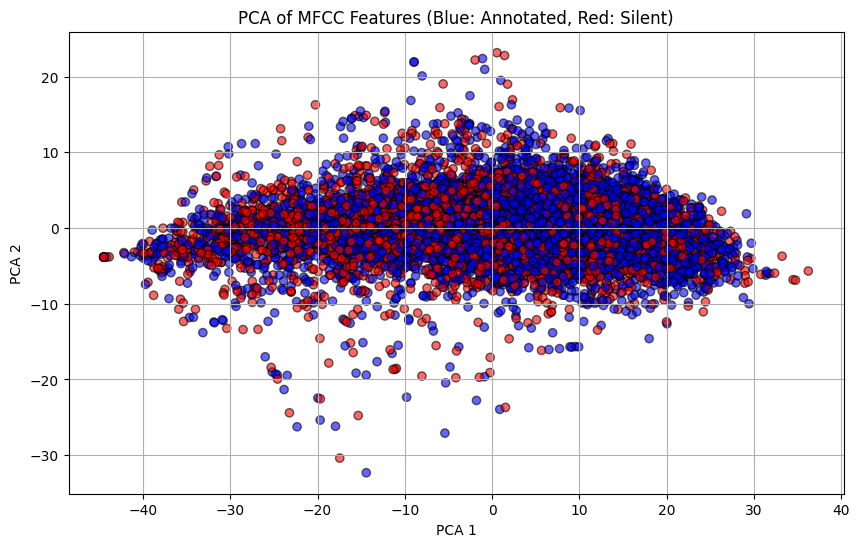

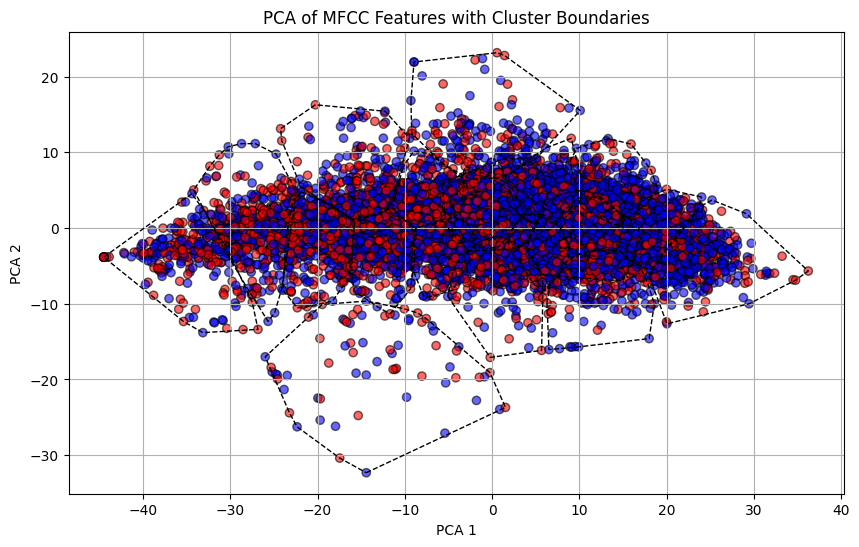

C:\Users\jeron\AppData\Local\Temp\ipykernel_46980\2438979078.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', N_CLUSTERS)  # Adjust the colormap as needed


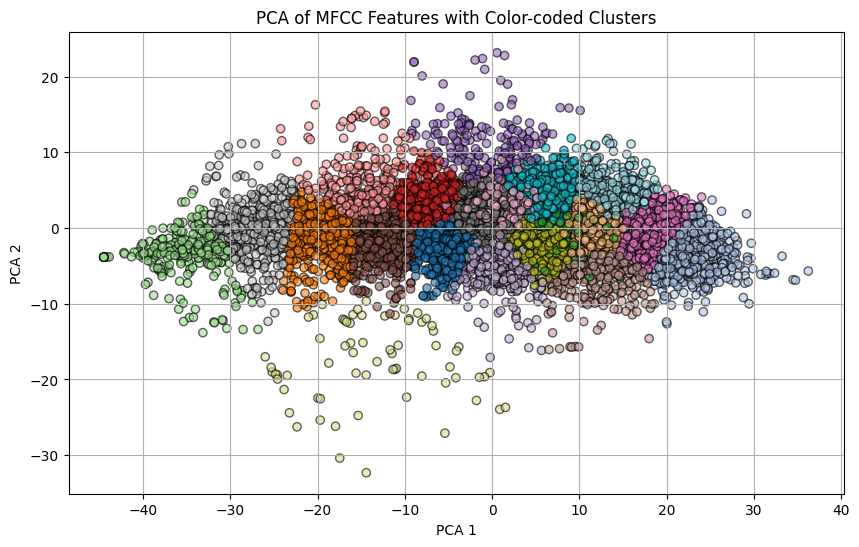

In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
import warnings
from scipy.spatial import ConvexHull
from matplotlib import cm

# --- SUPPRESS joblib CPU warnings ---
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

# --- CONFIG ---
ANNOTATIONS_CSV = "../annotations.csv"
AUDIO_FEATURE_FOLDER = "../audio_features"
FEATURE_KEY = "mfcc"
N_CLUSTERS = 20

# --- LOAD ANNOTATIONS ---
annotations = pd.read_csv(ANNOTATIONS_CSV)
annotations = annotations.sort_values(by=["filename", "onset"])
grouped = annotations.groupby("filename")

region_features = []
region_labels = []  # 'annotated' or 'silent'

for filename, group in grouped:
    feature_path = os.path.join(AUDIO_FEATURE_FOLDER, filename.replace(".mp3", ".npz"))
    if not os.path.exists(feature_path):
        print(f"Missing features for {filename}")
        continue

    features = np.load(feature_path)
    if FEATURE_KEY not in features:
        print(f"{FEATURE_KEY} not in {feature_path}")
        continue

    mfcc = features[FEATURE_KEY]
    duration = mfcc.shape[0]
    sr = 16000
    hop_length = 512
    frame_duration = hop_length / sr

    time_regions = []
    for _, row in group.iterrows():
        onset_idx = int(row['onset'] / frame_duration)
        offset_idx = int(row['offset'] / frame_duration)
        time_regions.append((onset_idx, offset_idx))

        if offset_idx > onset_idx and offset_idx <= mfcc.shape[0]:
            segment = mfcc[onset_idx:offset_idx]
            if segment.shape[0] == 0:
                continue
            region_feat = np.mean(segment, axis=0)
            if not np.isnan(region_feat).any():
                region_features.append(region_feat)
                region_labels.append("annotated")

    silent_regions = []
    prev_end = 0
    for onset_idx, offset_idx in time_regions:
        if onset_idx > prev_end:
            silent_regions.append((prev_end, onset_idx))
        prev_end = max(prev_end, offset_idx)
    if prev_end < duration:
        silent_regions.append((prev_end, duration))

    for start_idx, end_idx in silent_regions:
        if end_idx - start_idx <= 1:
            continue
        segment = mfcc[start_idx:end_idx]
        if segment.shape[0] == 0:
            continue
        region_feat = np.mean(segment, axis=0)
        if not np.isnan(region_feat).any():
            region_features.append(region_feat)
            region_labels.append("silent")

# --- CLEAN UP NaNs ---
X = np.array(region_features)
labels_array = np.array(region_labels)
mask = ~np.isnan(X).any(axis=1)
X_clean = X[mask]
labels_clean = labels_array[mask]

# --- CLUSTERING ---
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
cluster_ids = kmeans.fit_predict(X_clean)

# --- ANALYZE SILENT CLUSTERS ---
silent_cluster_ids = [cluster_ids[i] for i, lbl in enumerate(labels_clean) if lbl == "silent"]
silent_counts = Counter(silent_cluster_ids)

print("Silent region cluster distribution:")
for cluster, count in sorted(silent_counts.items()):
    print(f"Cluster {cluster}: {count} silent regions")

# --- VISUALIZE ---
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_clean)
colors = ['red' if lbl == 'silent' else 'blue' for lbl in labels_clean]

plt.figure(figsize=(10, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=colors, alpha=0.6, edgecolor='k')
plt.title("PCA of MFCC Features (Blue: Annotated, Red: Silent)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.scatter(X_2D[:, 0], X_2D[:, 1], c=colors, alpha=0.6, edgecolor='k')

for cluster_id in range(N_CLUSTERS):
    cluster_points = X_2D[cluster_ids == cluster_id]
    if cluster_points.shape[0] < 3:
        continue  # Need at least 3 points for a convex hull
    hull = ConvexHull(cluster_points)
    hull_pts = cluster_points[hull.vertices]
    hull_pts = np.append(hull_pts, [hull_pts[0]], axis=0)
    ax.plot(hull_pts[:, 0], hull_pts[:, 1], 'k--', lw=1)

plt.title("PCA of MFCC Features with Cluster Boundaries")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# --- COLOR-CODED CLUSTERS ---
colormap = cm.get_cmap('tab20', N_CLUSTERS)  # Adjust the colormap as needed
colors_by_cluster = [colormap(cluster_ids[i]) for i in range(len(cluster_ids))]

plt.figure(figsize=(10, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=colors_by_cluster, alpha=0.6, edgecolor='k')
plt.title("PCA of MFCC Features with Color-coded Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()